In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import pathlib
import matplotlib.pyplot as plt
import os, sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Turn data into Dataset object

In [2]:
main_dir = "data_transfer/"
main_dir = pathlib.Path(main_dir)
BATCH_SIZE = 32
IMG_SIZE = (244,244)

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir, 
    shuffle = True,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir, 
    shuffle = True, 
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE)

class_names = train_set.class_names
print(class_names)

Found 760 files belonging to 3 classes.
Found 760 files belonging to 3 classes.
['Oyaku_Don', 'Salmon', 'Satay']


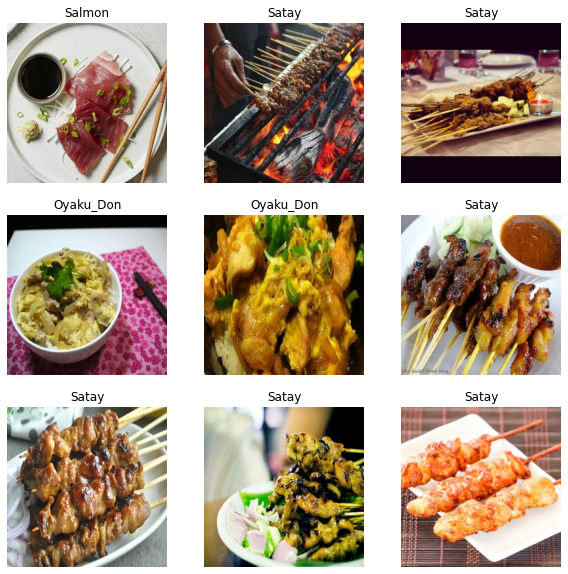

In [3]:
plt.figure(figsize = (10,10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(val_set)
print("Number of batches: %d" %val_batches)

test_dataset = val_set.take(val_batches // 5) 
val_dataset = val_set.skip(val_batches //5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of batches: 24
Number of validation batches: 20
Number of test batches: 4


In [5]:
train_dataset = train_set.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [6]:
#Augment data by flipping image and random rotation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)  ## Concatenating tuple 
## IMG_SIZE = (160,160) 
## IMG_SHAPE = (160,160) + (3,) = (160,160,3) 
## 160x160 3 channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()
print(IMG_SHAPE)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 122, 122, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 122, 122, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [8]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [10]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [11]:
inputs = tf.keras.Input(shape=(244,244,3))

### Alternative way to do Sequential
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics = ['accuracy'])
model.compile(optimizer='RMSprop',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 244, 244, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 244, 244, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [13]:
import time 
begin = time.time()
initial_epochs = 150
loss0, accuracy0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = val_dataset,
                   verbose = True,
                   callbacks = [callback])
model_time = time.time() - begin
print('Time taken for model: {:.1f} seconds'.format(model_time))

20/20 [==============================] - 3s 74ms/step - loss: 1.2063 - accuracy: 0.3117
initial loss: 1.21
initial accuracy: 0.31
Epoch 1/150
24/24 [==============================] - 5s 111ms/step - loss: 0.5719 - accuracy: 0.7908 - val_loss: 0.2480 - val_accuracy: 0.9557
Epoch 2/150
24/24 [==============================] - 3s 112ms/step - loss: 0.2497 - accuracy: 0.9303 - val_loss: 0.1443 - val_accuracy: 0.9715
Epoch 3/150
24/24 [==============================] - 3s 110ms/step - loss: 0.1573 - accuracy: 0.9553 - val_loss: 0.1130 - val_accuracy: 0.9747
Epoch 4/150
24/24 [==============================] - 3s 111ms/step - loss: 0.1277 - accuracy: 0.9645 - val_loss: 0.0909 - val_accuracy: 0.9699
Epoch 5/150
24/24 [==============================] - 3s 110ms/step - loss: 0.1084 - accuracy: 0.9711 - val_loss: 0.0774 - val_accuracy: 0.9778
Epoch 6/150
24/24 [==============================] - 3s 110ms/step - loss: 0.0896 - accuracy: 0.9789 - val_loss: 0.0595 - val_accuracy: 0.9842
Epoch 7/150


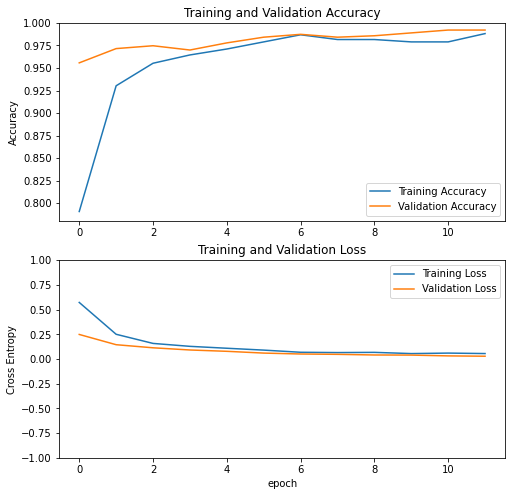

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1.0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
model_loss, model_accuracy = model.evaluate(val_dataset)
print('Accuracy on test dataset for model three:', model_accuracy)
print('loss:', model_loss)

20/20 [==============================] - 1s 55ms/step - loss: 0.0310 - accuracy: 0.9905
Accuracy on test dataset for model three: 0.9905063509941101
loss: 0.031014548614621162


Predictions:
 [1 2 2 1 2 0 1 0 2 1 1 2 0 2 1 1 2 1 1 2 0 0 2 2 1 1 1 2 1 0 2 2]
Labels:
 [1 2 2 1 2 0 1 0 2 1 1 2 0 1 1 1 2 1 1 2 0 0 2 2 1 1 1 2 1 0 2 2]


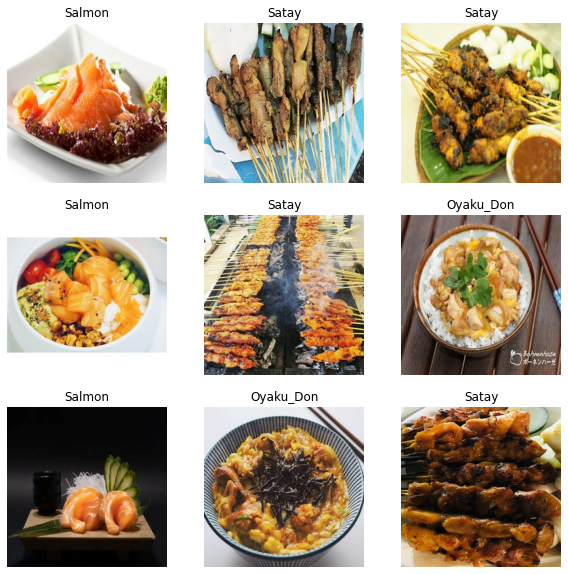

In [16]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
logit = model.predict_on_batch(image_batch)

# Apply a softmax to since our model returns logits
prediction = tf.nn.softmax(logit)
prediction = tf.argmax(prediction, axis = 1)
print('Predictions:\n', prediction.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction[i]])
  plt.axis("off")